## Q-Learning for Tic-Tac-Toe

In [1]:
import math
import copy
import numpy as np
import random
import matplotlib.pyplot as plt

playerA = 1
playerB = -1
empty = 0


class Agent():
    def __init__(self, player1=True, epsilon=1, eps_dec=0.000001, eps_min=0.08, learning_rate=0.1, discount_factor=0.9):
        if player1:
            self.player = 1
        else:
            self.player = -1
        self.epsilon = epsilon
        self.epsilon_min = eps_min
        self.epsilon_dec = eps_dec
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor

        self.Q_table = {}
        self.visited = []  # tracks visited states in the episode

    def select_action(self, state):
        t_state = tuple(state)
        action = 0
        legal_moves = [idx for idx, i in enumerate(t_state) if i == 0]
        if (t_state, 0) not in self.Q_table:
            for move in range(9):
                if (t_state, move) not in self.Q_table:
                    # adding possible moves
                    self.Q_table[(t_state, move)] = 0.05

        if random.random() > self.epsilon:  # if choosing 'optimal' move
            action_scores = [self.Q_table[t_state, move]
                             for move in legal_moves]  # get each legal action
            # get the best 'legal' action
            action_pos = np.argmax(action_scores)
            action = legal_moves[action_pos]  # find which action it relates to
        else:  # if random move
            action = random.choice(legal_moves)
        # store a list of 'visited' nodes
        self.visited.append((t_state, action))
        return action

    def minimax(self, depth, player):
        if depth == 0 or self.game_over():
            return [[], self.evaluate()]

        if player == self.playerA:
            best = [[], -math.inf]
        else:
            best = [[], math.inf]

        for move in self.valid_moves():
            row, col = move
            self.board[row][col] = player  # Make the move
            _, score = self.minimax(depth - 1, -player)
            self.board[row][col] = self.empty  # Undo the move

            if player == self.playerA:
                if score > best[1]:
                    best = [[move], score]
                elif score == best[1]:
                    best[0].append(move)
            else:
                if score < best[1]:
                    best = [[move], score]
                elif score == best[1]:
                    best[0].append(move)

        return best

    def learn(self, winner):
        # Reward
        reward = 1 if winner == self.player else (-1 if winner != 0 else -0.1)

        # Update states before the end
        for idx, (state, action) in enumerate(self.visited[:-1]):
            next_state, _ = self.visited[idx+1]
            max_Q = max([self.Q_table[(next_state, a)] for a in range(9)])
            self.Q_table[(state, action)] = self.Q_table[(state, action)] + \
                self.learning_rate * \
                (reward + self.discount_factor *
                 max_Q - self.Q_table[(state, action)])

        # Update the last state
        (last_state, last_action) = self.visited[-1]  # check update
        self.Q_table[(last_state, last_action)] = self.Q_table[(last_state,
                                                                last_action)] + self.learning_rate * (reward - self.Q_table[(last_state, last_action)])

        # clearing states visited for the episode
        self.visited = []
        self.epsilon -= self.epsilon_dec
        self.epsilon = max(self.epsilon_min, self.epsilon)


class Board:
    def __init__(self):
        # A flattened representation of the 3x3 tic-tac-toe board
        self.board = [0] * 9

    def reset(self):
        """Resets the board to its initial state."""
        self.board = [0] * 9

    def place_piece(self, position, player1=True):
        """Places a piece on the board at the given position."""
        if self.board[position] != 0:
            print("Invalid move")
            return False

        self.board[position] = 1 if player1 else -1
        return True

    def game_done(self):
        """Checks if the game is over (either win or draw)."""
        return self.evaluate() != 0 or self.board.count(0) == 0

    def evaluate(self):
        """Evaluates the current board state to determine the winner."""
        winning_combinations = [
            (0, 1, 2), (3, 4, 5), (6, 7, 8),
            (0, 3, 6), (1, 4, 7), (2, 5, 8),
            (0, 4, 8), (2, 4, 6)
        ]

        for a, b, c in winning_combinations:
            if self.board[a] == self.board[b] == self.board[c] and self.board[a] != 0:
                return self.board[a]

        return 0  # No winner yet

In [2]:
player1 = Agent()  # player 1 plays O's
player2 = Agent(player1=False)  # player 2 plays X's
players = [player1, player2]
board = Board()
vals = []
x_val = []
x_val_1 = []
n_games = 1000000
state = (1, 0, 0, 0, 0, 0, 0, 0, 0)
for game in range(n_games):
    board.reset()  # reset board
    while not board.game_done():
        board.place_piece(player1.select_action(board.board))
        if board.game_done():
            break
        board.place_piece(player2.select_action(
            board.board), player1=False)

    # Learn from the game
    winner = board.evaluate()
    [player.learn(winner) for player in players]

    # Store a specific normalized Q-table for future visualization
    if game > 10000:
        for i in range(9):
            try:
                vals.append(player2.Q_table[(state, i
                                             )])
            except KeyError:
                continue
        for i in range(9):
            vals.append(player2.Q_table[(state, i
                                         )])
        if min(vals) != max(vals):
            x_val.append((np.array(vals)-min(vals))/(max(vals)-min(vals)))
            vals = []

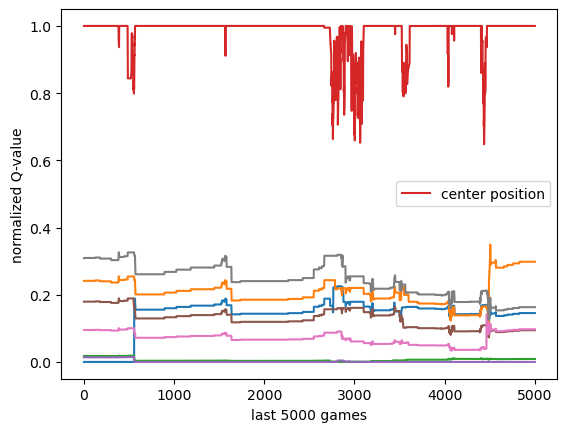

In [3]:
def print_q_table(state):
    """
    Print the q-board.
    """
    val = []

    if state.count(1) == state.count(-1):
        player = player1
    elif state.count(1) == state.count(-1)+1:
        player = player2
    else:
        return ('Not a valid state!')

    for i in range(0, 9):
        val.append(player.Q_table[(state, i
                                   )])
    table = val
    print(f"The unormalized Q-table for state {state} is:")
    for i in range(3):
        print(" | ".join(str(round(table[(3*i+j)], 3))if str(
            round(table[(3*i+j)], 3)) != '0.05' else '*' for j in range(3)))
        print("-" * 25)


for i in range(1, 9):
    x = [j[i] for j in x_val]
    x = x[-5000:]

    y_val = np.linspace(0, len(x), len(x))
    if i == 4:
        plt.plot(y_val, x, label='center position')
    else:
        plt.plot(y_val, x)
plt.legend()
plt.ylabel('normalized Q-value')
plt.xlabel('last 5000 games')
plt.show()

In [4]:
state = (1, 0, 1, -1, -1, 0, 0, 0, 0)
print_q_table(state)

The unormalized Q-table for state (1, 0, 1, -1, -1, 0, 0, 0, 0) is:
* | 1.0 | *
-------------------------
* | * | 2.635
-------------------------
0.033 | -0.551 | -0.176
-------------------------


## Test the percentage of draws in the game 

We let the two players play additional rounds of the game to analyze the percentage of draws.

In [15]:
i = 0
N = 100000
player1.epsilon = 0.001 # Set a smaller epsilo, so players can more reply on the q-table we got
player2.epsilon = 0.001
for _ in range(N):

    board.reset()  # reset board
    while not board.game_done():
        board.place_piece(player1.select_action(board.board))
        if board.game_done():
            break
        board.place_piece(player2.select_action(
            board.board), player1=False)

    if board.evaluate() == 0:
        i += 1

print(f'Percentage of draw: {round(i/N*100,2)}%.')

Percentage of draw: 99.65%.
